<a href="https://colab.research.google.com/github/neha-rapolu001/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

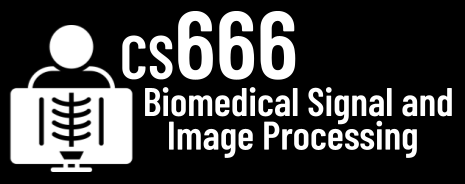
#Assignment 4

In [95]:
# NAME: Neha Rapolu

In [96]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [97]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['clf', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [98]:
# we are using mahotas again, so lets install it!
!pip install mahotas

In [99]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [100]:
# Please download this file: https://cs666.org/data/xray/ with the wget command!
# Note: Please use the forwarded dropbox link and change dl=0 to dl=1!
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
!wget https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1

--2024-04-05 01:15:35--  https://www.dropbox.com/s/2ca2889o2ql8n4e/xray.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/2ca2889o2ql8n4e/xray.zip [following]
--2024-04-05 01:15:36--  https://www.dropbox.com/s/dl/2ca2889o2ql8n4e/xray.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc798077f642d3e3ea2ec4986a11.dl.dropboxusercontent.com/cd/0/get/CQbwkhQtOW0u6osAeR8aOthm7Ea6iapcKpq3cYKowAsPTI9jha8_lKiV-sFMF_3ZJ7N30PlJHZGaG8plcaHi4zURsKMqhZYnXVp5FtW1_lWXS8dYgt0pc0vmckQc22CLudmOiSwJCZ1IbjJnvyKvG3st/file?dl=1# [following]
--2024-04-05 01:15:36--  https://uc798077f642d3e3ea2ec4986a11.dl.dropboxusercontent.com/cd/0/get/CQbwkhQtOW0u6osAeR8aOthm7Ea6iapcKpq3cYKowAsPTI9jha8_lKiV-sFMF_3ZJ7N30PlJHZGaG8plcaHi4zURsKMqhZYnXVp5FtW1_lWXS8dY

In [101]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [102]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

In [103]:
# TODO: Please display this image and print the dimensions!

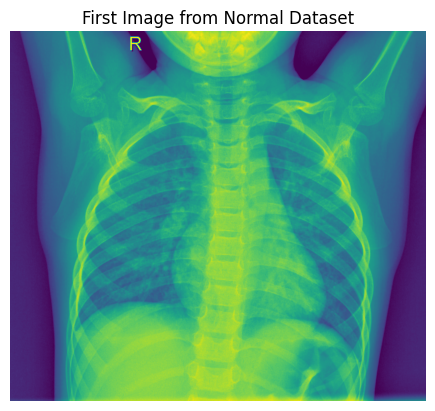

Image dimensions: (1858, 2090)


In [104]:
# TODO: YOUR CODE

plt.imshow(img)
plt.title('First Image from Normal Dataset')
plt.axis('off')
plt.show()

# Print dimensions
print("Image dimensions:", img.shape)

**Task 2:** Let's do some data wrangling and more visualization! [30 Points]

In [105]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [106]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) Loading and Organizing Images
# TODO: Operation 2) Data Cleaning and Preprocessing (Resizing Images)
# TODO: Operation 3) Data Transformation (Converts images into numerical representations for machine learning)

In [107]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images

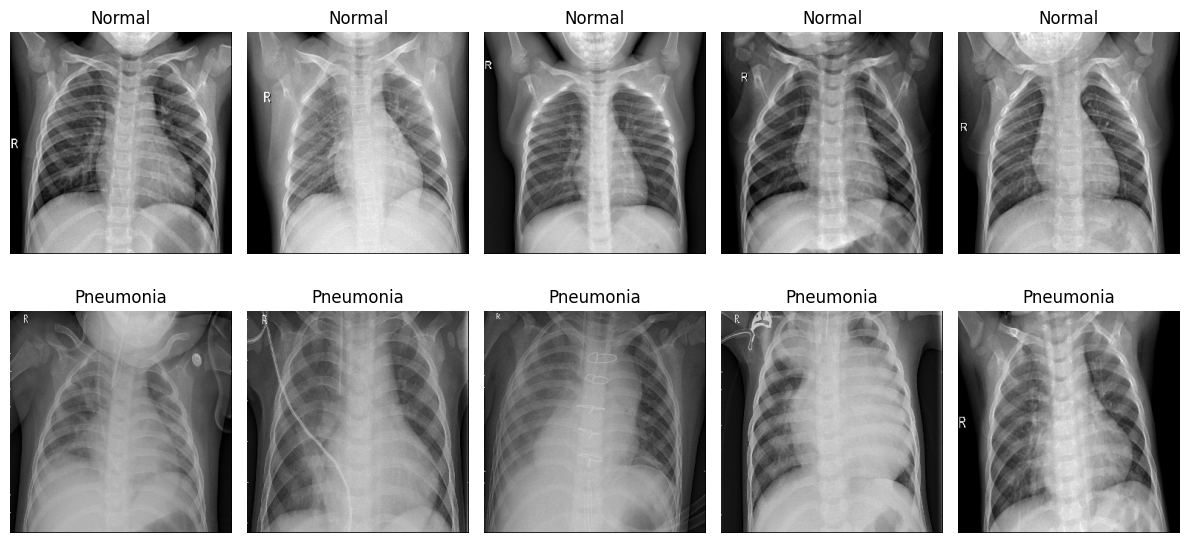

In [108]:
# TODO: YOUR CODE

# Define the number of images to display
num_images = 5

# Visualize the first 5 normal images
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(data[0][i], cmap='gray')
    plt.title('Normal')
    plt.axis('off')

# Visualize the first 5 pneumonia images
for i in range(num_images):
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(data[1][i], cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Task 3:** Setup training and testing data. [15 Points]

In [109]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [110]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [111]:
# TODO: Please create the y_train vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

y_train = np.concatenate([
    np.zeros(TRAINING_COUNT),  # Label 0 for normal images
    np.ones(TRAINING_COUNT),   # Label 1 for pneumonia images
    np.full(TRAINING_COUNT, 2) # Label 2 for covid images
], axis=0)

In [112]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[TRAINING_COUNT:TRAINING_COUNT+TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [113]:
# TODO: Please create the y_test vector with 0 for a normal image,
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.

y_test = np.concatenate([
    np.zeros(TESTING_COUNT),  # Label 0 for normal images
    np.ones(TESTING_COUNT),   # Label 1 for pneumonia images
    np.full(TESTING_COUNT, 2) # Label 2 for covid images
], axis=0)

**Task 4:** Let's train and evaluate the Random Forest! [30 Points]

In [114]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [115]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [116]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [117]:
# TODO: In just a few sentences, please explain how the Random Forest works.

In [118]:
# TODO: A Random Forest works by creating multiple decision trees, each trained on a random subset of features and data points (bootstrapping).
# These trees then "vote" to classify a new data point.
# The final prediction is based on the majority vote (classification) or the average (regression) of the individual tree predictions.
# This approach reduces the risk of overfitting the training data and generally leads to more robust and accurate models.

In [119]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

0.875

In [120]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [121]:
# TODO: I think the accuracy is reasonably good for a classification model. And I'm not surprised to see the accuracy as 89%.

**Task 5:** Now, let's decrease the number of trees! [10 Points]

In [122]:
# How many trees are used in Task 4?

In [123]:
# TODO: 100

num_trees = clf.n_estimators
print("Number of trees used:", num_trees)

Number of trees used: 100


In [124]:
# Now, please use a single tree and observe the testing performance.

In [134]:
# TODO: YOUR CODE

from sklearn.ensemble import RandomForestClassifier

single_tree_clf = RandomForestClassifier(n_estimators=1)
single_tree_clf.fit(X_train, y_train)
single_tree_accuracy = single_tree_clf.score(X_test, y_test)

print(single_tree_accuracy)

0.7916666666666666


In [126]:
# Are you surprised?

In [127]:
# TODO: Yes I'm surprised. Because I thought the accuracy would be way worse.

**Bonus:** Let's take a closer look! [33 Points]

In [128]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [135]:
# TODO: YOUR CODE AND YOUR ANSWER

# Obtain the remaining COVID images
X_remaining_covid = np.zeros((99, 300*300), dtype=np.float32)
t_pos = 0

for image in data[2][100:]:
    image_flat = image.ravel()  # flatten the image
    image_flat /= image_flat.max()  # normalize the image
    X_remaining_covid[t_pos] = image_flat
    t_pos += 1

predictions_remaining_covid = fitted.predict(X_remaining_covid)
true_labels_remaining_covid = np.full(99, 2)
accuracy_remaining_covid = np.mean(predictions_remaining_covid == true_labels_remaining_covid)

print(accuracy_remaining_covid)



0.8888888888888888


In [130]:
# Can you figure out which images were misclassified?
# Hint: You can use predictions = clf.predict(X_test_covid_only) for this.
# Can you display them?
# Do you have an idea why these images were problematic?

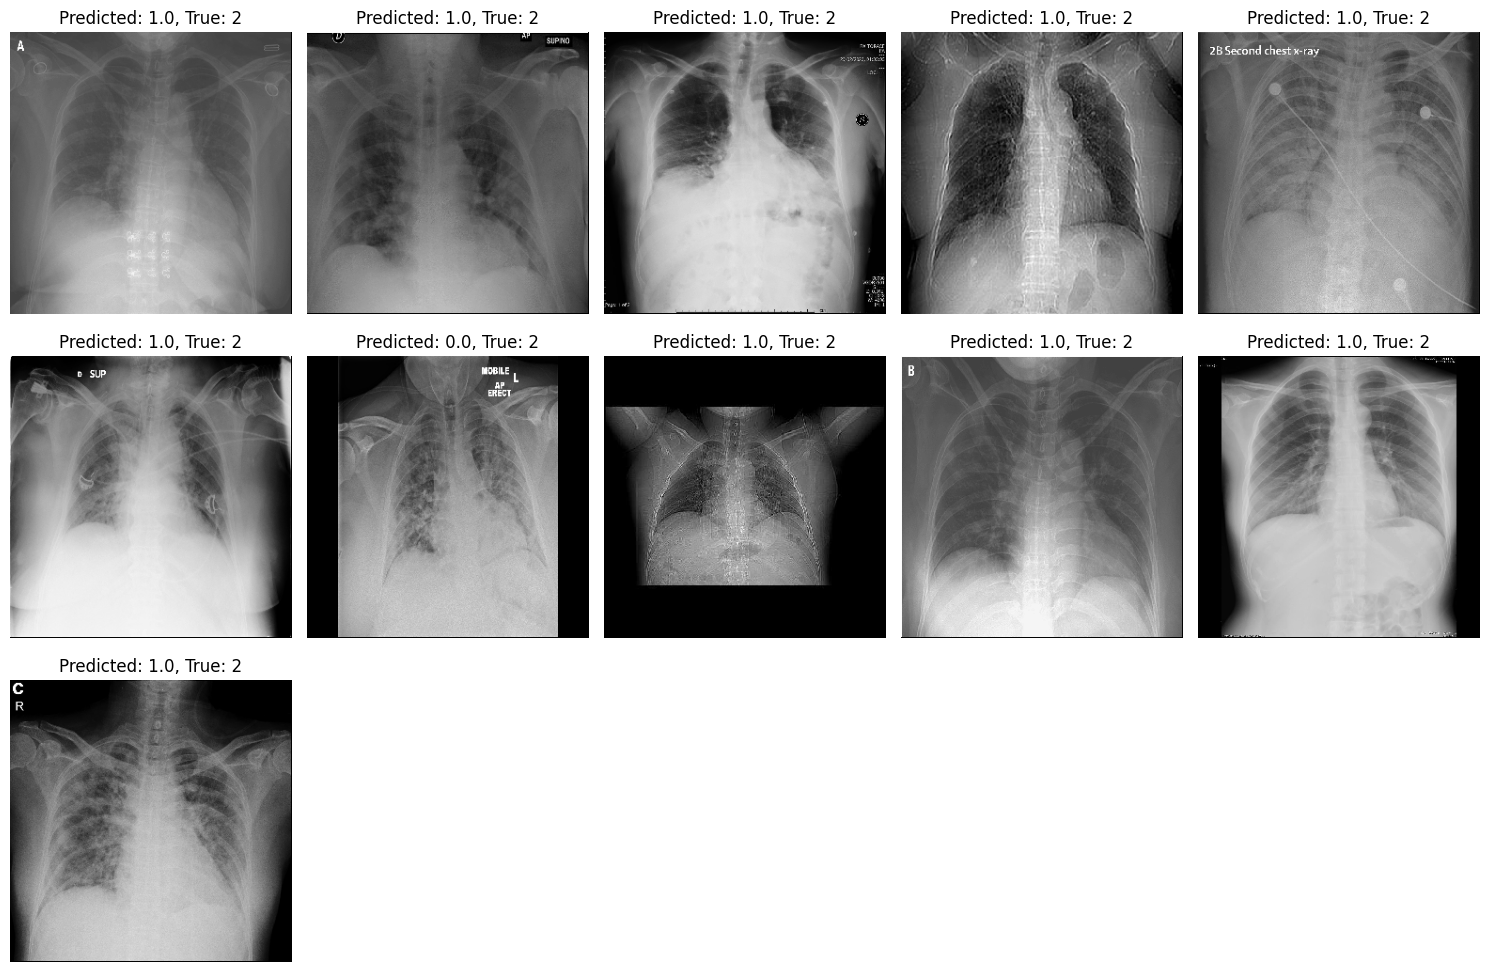

In [136]:
# TODO: YOUR CODE AND YOUR ANSWER

# Find misclassified indices
misclassified_indices = np.where(predictions_remaining_covid != true_labels_remaining_covid)[0]

# Display misclassified images
import matplotlib.pyplot as plt

num_cols = 5
num_rows = (len(misclassified_indices) // num_cols) + 1

plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_remaining_covid[idx].reshape(300, 300), cmap='gray')
    plt.title(f"Predicted: {predictions_remaining_covid[idx]}, True: {true_labels_remaining_covid[idx]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [132]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw